# Reusing Software Kernels

## Goals

* Learn how to build an application from the library of available software kernels

* See an example of multicasting data from the memory tile

---


## Build a Color Detection Application

We are going to build a simpler version of the color detection application we saw in a previous notebook. The image below shows the data flow graph that we are going to implement:

<center><img src="./images/png/color_detect_dev_dfg.png" style="max-height: 150px; width:auto; height:auto;"></center>
<center><strong>Color detection data flow graph</strong></center>

* `rgb2hsv()` converts the RGBA input image to [HSV (Hue Saturation Value)](https://en.wikipedia.org/wiki/HSL_and_HSV). This will allow us to use Hue to select a range of colors to filter. 

* `inRange()` is used for color-based image segmentation. It can isolate or filter out pixels in an image that fall within a specified color range, while ignoring the pixels outside that range. The hue value of each pixel will be compared against a range of values that you can specify. The range of values are passed as runtime parameters to the software kernel. 

   The output of `inRange()` is effectively a mask where pixels within the range are set to their max value, or set to zero if they are outside the range. 
  
* `rgb2gray()` converts the output to grayscale. 
   
* `bitwiseand()` carries out a bitwise AND between the mask and the original input image. Pixels within the range will be unchanged. Pixels outside the range will be filtered out. This will be the output returned from the application.   

In this example the `rgb2hsv` and `bitwiseand` software kernels will be mapped to two different compute tiles. Both these software kernels need the input data as indicated in the graph. You will see how the input data is *multicast* by the memory tile to the two software kernels.  

<div class="alert alert-info" role="info">
  <i>Broadcast</i> sends data from one source to <i>every</i> node in a system. <i>Multicast</i> sends data from one source to <b>selected</b> nodes in the system.
</div>



### Import kernels and modules

Start by importing the software kernels that we will use in the design:

In [1]:
from npu.lib import Rgba2Hue, Gray2Rgba, BitwiseAnd, InRange

Next import the modules we will need:

In [2]:
import numpy as np

from npu.build.appbuilder import AppBuilder
from npu.build.mtkernel import MTPassThrough # Memory Tile modules

### Create the color detection application class

* Instantiate each of the kernels in the `__init__` method. 
* Define the call graph as per the dataflow graph.

As before, this application will process 720p (1280x720) RGBA images, and one row will be passed to the application for each iteration.


In [3]:
class ColorDetectApplication(AppBuilder):

    def __init__(self):
        self.rgba2hue = Rgba2Hue()
        self.inrange = InRange()
        self.gray2rgba = Gray2Rgba()
        self.bitwiseand = BitwiseAnd()
        self.mtbuffer_in = MTPassThrough()
        super().__init__()

    def callgraph(self, x_in:np.ndarray, x_out:np.ndarray) -> None:
        rows = x_in.shape[0]
        bytes_per_row = x_in.shape[1] * x_in.shape[2]
        for row in range(rows):
            multicast_data = self.mtbuffer_in(x_in[row])
            rgba2hue_output = self.rgba2hue(multicast_data, bytes_per_row)
            inrange_output = self.inrange(rgba2hue_output, x_in.shape[1], 0, 79)
            gray2rgba_output = self.gray2rgba(inrange_output, x_in.shape[1])
            bitwiseand_output = self.bitwiseand(gray2rgba_output, multicast_data, bytes_per_row)
            x_out[row] = bitwiseand_output

### Memory tile multicast 

Notice that `multicast_data` is the output or returned object from the `MTPassThrough()` method. `multicast_data` is then used as an input parameter to both `rgba2hue()` and `bitwiseand()`. When building the graph for this application, the Riallto *tracer* will determine the connections between software kernels. It will implement the movement of this data as a multicast from the memory tile to the two software kernels.

In this example we only need to multicast to two compute tiles. In larger application we can use multicast to send data to many compute tiles. The mechanism is the same when data is sent from a memory tile to all (compute) tiles, but rather than call this "multicast", the correct terminology for this operation is "broadcast". 

### Instantiate the color detection class

Declare an instance of the class and allocate an input and an output buffer. 

In [4]:
app_builder = ColorDetectApplication()

x_in = np.zeros(shape=(720, 1280, 4), dtype=np.uint8)
x_out = np.zeros(shape=(720, 1280, 4), dtype=np.uint8)

### Build the color detection application

In [5]:
app_builder.build(x_in, x_out)

Using cached rgba2hue kernel object file...
Using cached in_range kernel object file...
Using cached gray2rgba kernel object file...
Using cached bitwiseand kernel object file...
Building the xclbin...
Successfully Building Application... ColorDetectApplication.xclbin & ColorDetectApplication.seq delivered


## Visualize the Application

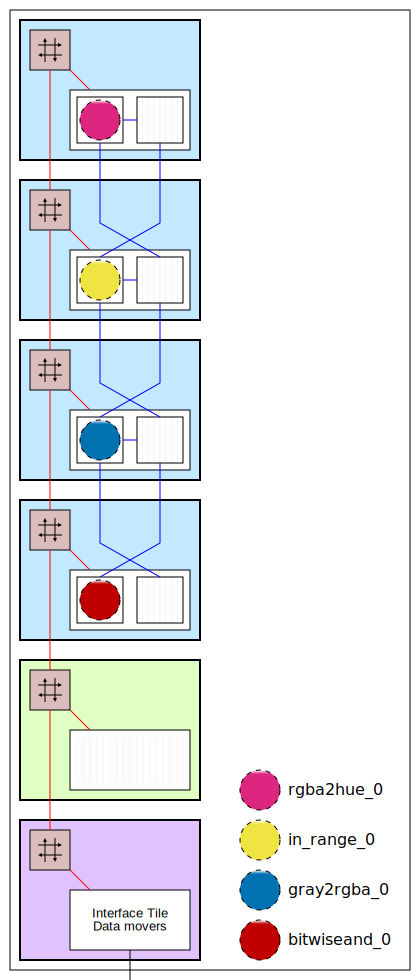

In [6]:
app_builder.display()

You can see how each of the four software kernels has been mapped to the NPU column and how data moves between kernels. Notice that the memory tile multicasts data to the top compute tile (`rgba2hue_0` software kernel) and to the bottom compute tile (`bitwiseand_0`). This is the fork in the dataflow graph we saw earlier. 

In the animation you can also see that `in_range_0` consumes data from the `rgba2_hue_0` output buffer directly via nearest neighbor communication. The same happens for `gray2rgba_0` and `bitwiseand_0` consuming data from the data memory at its north, which correspond to the output data from `rgba2_hue_0` and `gray2rgba_0` respectively. 

Note that in this application we are using both nearest-neighbor communication and data movers to transfer intermediate results between tiles.

### Run the application

We are going to load the application in the NPU using the `ImageLooper720p` visualization helper.

In [7]:
from npu.lib.graphs.image_looper_720p import ImageLooper720p

app = ImageLooper720p(img='images/jpg/ryzenai_future_starts_now.jpg',
                      xclbin='ColorDetectApplication.xclbin',
                      rtps={"range_low" : { "type": "hueslider", "min": 0, "max" : 255, "rangehigh": "range_high", "name": "Hue range"}})

In [8]:
app.start()

Image(value=b'', format='jpeg')

Button(description='Stop', style=ButtonStyle())


---


## Exercise for the Reader

In this exercise, you are going to work with grayscale input and output images. As you can see the in the image below, there are two working branches. The edges will be overlaid on the inverse of the input image. The source image is multicast to the `filter2D` and to the `inverse` kernels, the output of the `filter2D` processed by the `threshold` kernel. Finally, the edges are overlaid on top of the inverse image using the `bitwiseor` kernel.

<center><img src="./images/png/edge_detect_exercise_reader.png" style="max-height: 180px; width:auto; height:auto;"></center>
<center><strong>Edge detection exercise for the reader</strong></center>

### Define your pipeline application

Import the necessary components and define your `callgraph`.

For the `ThresholdGrayscale` kernel, set:

- `max_val` to 255
- `threshold_type` to `0`

For the `Filter2d` note that we are using `f2doperator` to define the kernel operator for the convolution. The operation `*f2doperator.tolist()` unpacks the nine values and pass them as argument to the kernel call. Do not forget to multiply them by 4096 (already done in the code). 

In [ ]:
from npu.build.appbuilder import AppBuilder
from npu.build.mtkernel import MTPassThrough
from npu.lib import ... # Import the , Filter2D and ThresholdGrayscale, bitwiseor, Inverse
import numpy as np

class InverseEdgeDetectApplication(AppBuilder):

    def __init__(self):
        # create an instance of the necessary kernels
        self.filter2d = ... # instantiate filter2d
        self.threshold = ... # instantiate threshold grayscale
        self.inverse = ... # instantiate inverse
        self.bitor = ... # instantiate bitwise or
        self.mtbuffer_in = ... # MTPassThrough
        super().__init__()

    def callgraph(self, x_in: np.ndarray, x_out: np.ndarray) -> None:
        f2doperator = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype = np.int16).reshape(9) * 4096
        rows = x_in.shape[0]
        for row in range(rows):
            input_buffer = ... # call MTPassThrough
            filter2d_buffer = self.filter2d(input_buffer, *f2doperator.tolist())
            # <your code goes here>
            output = self.bitor(threshold_buffer, inverse_buffer, ...) # call bitwiseor 
            x_out[t] = output

Display and build your application.

In [ ]:
# define input and output grayscale buffers
x_in = np.zeros(shape=(720, 1280), dtype=np.uint8)
x_out = np.zeros(shape=(720, 1280), dtype=np.uint8)

app_builder = InverseEdgeDetectApplication()
app_builder(x_in, x_out)

app_builder.display()

If you are happy with the kernel placement, build your application. Otherwise, use the `tloc` attribute to place the kernels.

In [ ]:
app_builder.build(x_in, x_out)

### Run your custom application

Once built, load your custom application in the NPU, run it and show the results:

In [ ]:
from npu.utils import OpenCVImageReader, image_plot
from npu.runtime import AppRunner

app = AppRunner('InverseEdgeDetectApplication.xclbin')

# Allocate app input and output buffers to exchange data with NPU
input_image = app.allocate(shape=(720, 1280), dtype=np.uint8)
output_image = app.allocate(shape=(720, 1280), dtype=np.uint8)

# Load RGBA 720p image into input_image buffer
img = OpenCVImageReader('images/jpg/ryzenai_future_starts_now.jpg', grayscale=True).img
input_image[:] = img
# Pass input_image buffer to NPU
input_image.sync_to_npu()

# Run app on NPU
app.call(input_image, output_image)

# Get results from NPU via output_image buffer
output_image.sync_from_npu()

# Plot source and result images
image_plot(input_image, output_image)

Do not forget to clean up the application.

In [ ]:
del app

You can also use the `VideoApplication` helper function to feed your application from the webcam.

In [ ]:
from npu.lib import VideoApplication, pxtype

app = VideoApplication('InverseEdgeDetectApplication.xclbin', pxtype_in=pxtype.GRAY, pxtype_out=pxtype.GRAY)
app.rtps = {} # add list of desired RTPs
app.start()

## Conclusion

By reusing software kernels from the Riallto library, you saw how to create and build a new NPU application. You can create new software kernels and reuse existing kernels from the Riallto library to create new custom applications. 


---

<center>
Copyright&copy; 2023 AMD, Inc
</center>
<center>
SPDX-License-Identifier: MIT
</center>